In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r '/content/drive/Othercomputers/T14S-G14/D:/HCMUT_Workspace/HK251/Digital-Image-Processing-and-Computer-Vision/assignment/landscape2art' /content/

In [ ]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from conv_autoencoder import ConvAutoencoder
from resnet_autoencoder import ResnetAutoencoder

In [ ]:
DIR = '/content/landscape2art'

## Prepare Dataset and Dataloader

In [ ]:
class PhotoPaintingDataset(Dataset):
    """
    A dataset for paired image-to-image tasks.
    Expects:
        root/photos/xxx.jpg
        root/sketches/xxx.jpg
    with matching filenames in both folders.
    """
    def __init__(self, photos_dir, paintings_dir, indices=None):
        self.photos_dir = photos_dir
        self.paintings_dir = paintings_dir

        # Ensure paired correctly (same length & matching names)
        assert len(os.listdir(photos_dir)) == len(os.listdir(paintings_dir)), \
            "Mismatch in number of files between photos and sketches."

        self.filenames = os.listdir(photos_dir)
        # If indices (train/test) are passed, keep only those
        if indices is not None:
            self.filenames = [self.filenames[i] for i in indices]

        # Match file names in both folders
        self.filenames = sorted(self.filenames)

        self.transformer = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photos_dir, self.filenames[idx])
        painting_path = os.path.join(self.paintings_dir, self.filenames[idx])

        photo = Image.open(photo_path).convert("RGB")
        painting = Image.open(painting_path).convert("RGB")  # paintingscale target

        photo = self.transformer(photo)
        painting = self.transformer(painting)

        return photo, painting

In [ ]:
photos_dir = os.path.join(DIR, 'monet_style_dataset', 'original')
paintings_dir = os.path.join(DIR, 'monet_style_dataset', 'stylized')

all_files = sorted(os.listdir(photos_dir))
train_idx, test_idx = train_test_split(range(len(all_files)), test_size=0.2, random_state=42)

train_dataset = PhotoPaintingDataset(photos_dir, paintings_dir, indices=train_idx)
test_dataset = PhotoPaintingDataset(photos_dir, paintings_dir, indices=test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Train and Evaluate function

In [ ]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    model.train()
    num_batches = len(train_loader)
    train_loss_lst = []
    eval_loss_lst = []
    
    print("🚀 Starting Training...")
    print("=" * 60)
    
    for epoch in range(num_epochs):
        train_loss = 0
        print(f"Epoch [{epoch+1}/{num_epochs}]: ")
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:2d}/{num_epochs}", 
                   ncols=100, ascii=True, leave=False)
        
        for batch_idx, (photo, painting) in enumerate(pbar):
            photo, painting = photo.to(device), painting.to(device)
            # Forward pass
            output = model(painting)
            loss = criterion(output, photo)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                progress = (batch_idx + 1) / num_batches * 100
                bar = "█" * int(progress // 5) + "░" * (20 - int(progress // 5))
                pbar.set_description(f"Epoch {epoch+1:2d}/{num_epochs} [{bar}]")

        train_loss = evaluate(model, criterion, train_loader, device)
        print(f"Training Loss: {train_loss:.4f}")

        eval_loss = evaluate(model, criterion, val_loader, device)
        print(f"Validation Loss: {eval_loss:.4f}")

        train_loss_lst.append(train_loss)
        eval_loss_lst.append(eval_loss)
    return train_loss_lst, eval_loss_lst

def evaluate(model, criterion, test_loader, device) -> float:
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for photo, painting in test_loader:
            photo, painting = photo.to(device), painting.to(device)
            # Forward pass
            output = model(painting)
            loss = criterion(output, photo)

            eval_loss += loss.item()
    eval_loss = eval_loss / len(test_loader)
    return eval_loss

## Train and Evaluate ConvAutoencoder

In [ ]:
hidden_channels = [64, 128, 256]
learning_rate = 1e-3
NUM_EPOCHS = 25

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder(in_channel=3, out_channel=3, hidden_channels=hidden_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_lst, eval_loss_lst = train(model, optimizer, criterion,
                                      train_loader, test_loader, num_epochs=NUM_EPOCHS, device=device)

Epoch [1/25]: 
Training Loss: 0.0573
Validation Loss: 0.0600
Epoch [2/25]: 


KeyboardInterrupt: 

In [ ]:
# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save entire model
model_path = os.path.join(DIR, 'models', f'ConvAutoencoder_{timestamp}.pth')
torch.save(model, model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/Othercomputers/T14S-G14/D:/HCMUT_Workspace/HK251/Digital-Image-Processing-and-Computer-Vision/assignment/landscape2art/models/ConvAutoencoder_20251002_103129.pth


In [ ]:
def plot_losses(train_loss_lst, eval_loss_lst):
    # Plot training and evaluation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss_lst) + 1), train_loss_lst, label='Training Loss', marker='o')
    plt.plot(range(1, len(eval_loss_lst) + 1), eval_loss_lst, label='Validation Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, len(train_loss_lst) + 1))
    plt.tight_layout()
    plt.show()

plot_losses(train_loss_lst, eval_loss_lst)

NameError: name 'train_loss_lst' is not defined

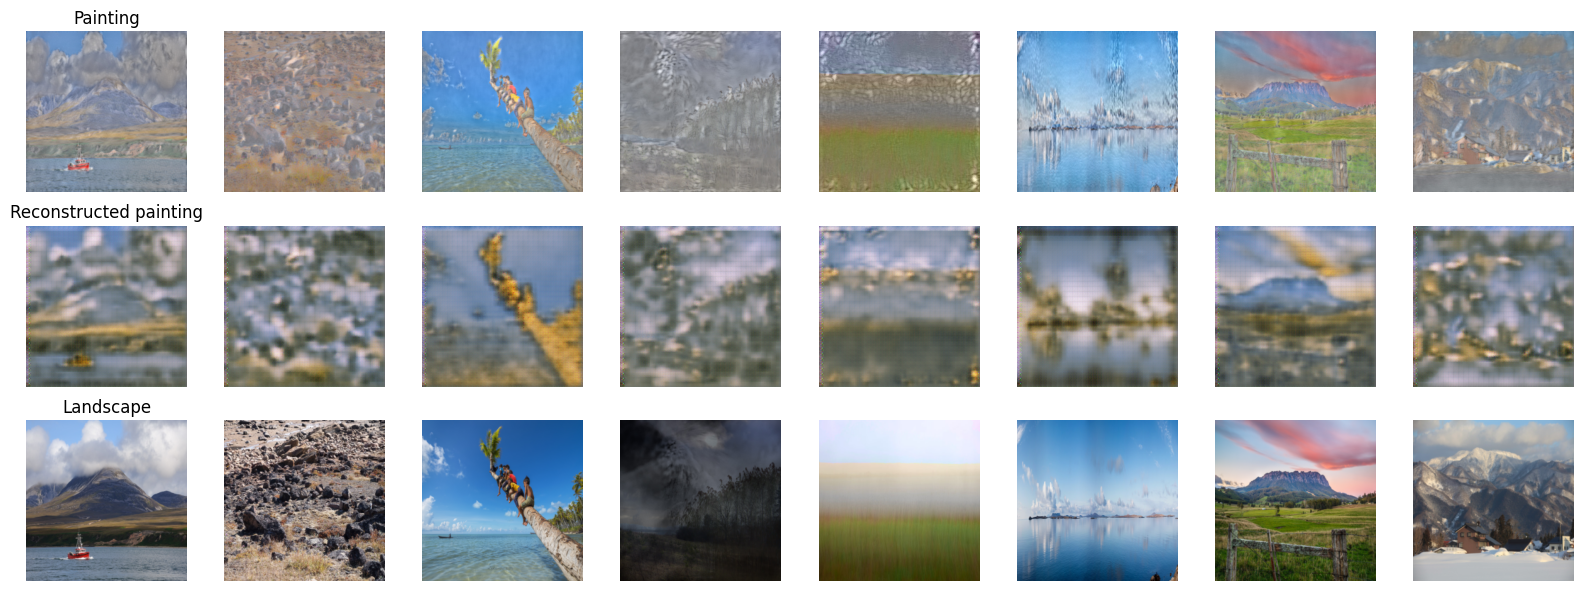

In [ ]:
def show_examples(model, data_loader, idx, device):
    model.eval()
    with torch.no_grad():
        it = iter(data_loader)
        photo, painting = next(it)
        for i in range(idx):
          photo, painting = next(it)

        painting, photo = painting.to(device), photo.to(device)
        output = model(painting)

        painting = painting.cpu().numpy()
        photo = photo.cpu().numpy()
        output = output.cpu().numpy()

        fig, axes = plt.subplots(3, 8, figsize=(16, 6))
        for i in range(8):
            # Display paintingscale input
            axes[0, i].imshow(painting[i].transpose(1, 2, 0))
            axes[0, i].axis('off')
            # Display predicted photo output
            axes[1, i].imshow(output[i].transpose(1, 2, 0))
            axes[1, i].axis('off')
            # Display ground truth
            axes[2, i].imshow(photo[i].transpose(1, 2, 0))
            axes[2, i].axis('off')

        axes[0, 0].set_title("Painting")
        axes[1, 0].set_title("Reconstructed painting")
        axes[2, 0].set_title("Landscape")
        plt.tight_layout()
        plt.show()

show_examples(model, test_loader, 6, device)